In [7]:
#@title Setup Repository
import os
from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'torch'

In [2]:
experiment_type = 'ffhq_encode'
EXPERIMENT_DATA_ARGS = {
    "ffhq_encode": {
        "model_path": "pretrained_models/best_model.pt",
        "image_path": "notebooks/images/1-2.jpg"
    },
}
# Setup required image transformations
EXPERIMENT_ARGS = EXPERIMENT_DATA_ARGS[experiment_type]
if experiment_type == 'cars_encode':
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
            transforms.Resize((192, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 192)
else:
    EXPERIMENT_ARGS['transform'] = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    resize_dims = (256, 256)

In [3]:
print(EXPERIMENT_DATA_ARGS['ffhq_encode']['image_path'][17:])
print(type(EXPERIMENT_ARGS['image_path']))
print(EXPERIMENT_ARGS['image_path'])

1-2.jpg
<class 'str'>
notebooks/images/1-2.jpg


In [4]:
model_path = EXPERIMENT_ARGS['model_path']
ckpt = torch.load(model_path, map_location='cpu')
# using opts from ckpt
opts = ckpt['opts']
# pprint.pprint(opts)  # Display full options used
# update the training options. add checkpoint_path key and value
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading e4e over the pSp framework from checkpoint: pretrained_models/best_model.pt
Model successfully loaded!


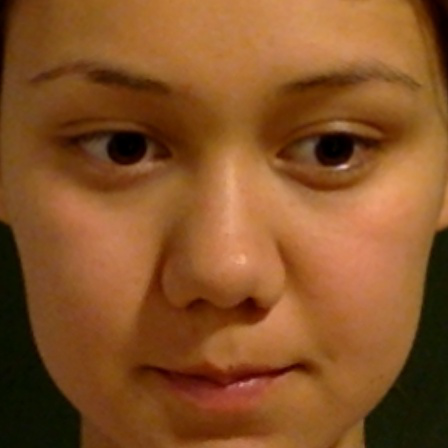

In [5]:
image_path = EXPERIMENT_DATA_ARGS[experiment_type]["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
original_image

In [6]:
img_transforms = EXPERIMENT_ARGS['transform']
print(img_transforms)

# input PIL Image transform with torch
# PIL -> tensor
print(type(original_image))
transformed_image = img_transforms(original_image)
print(type(transformed_image))
# 448 input image -> 256 transformed image
print(transformed_image.size())

Compose(
    Resize(size=(256, 256), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
<class 'PIL.Image.Image'>
<class 'torch.Tensor'>
torch.Size([3, 256, 256])


In [7]:
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(result_image.resize(resize_dims)),
                          np.array(source_image.resize(resize_dims))], axis=1)
    result_image = Image.fromarray(res)
    return result_image

def run_on_batch(inputs, net):
    images, latents = net(inputs.to("cuda").float(), randomize_noise=False, return_latents=True)
    if experiment_type == 'cars_encode':
        images = images[:, :, 32:224, :]
    return images, latents

In [8]:
with torch.no_grad():
    tic = time.time()
    # PIL -> tensor -> runonbatch
    images, latents = run_on_batch(transformed_image.unsqueeze(0), net)
    result_image, latent = images[0], latents[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))
    # print(torch.equal(result_image_latent[0], latent))
    print(latent.shape)

Inference took 0.1038 seconds.
torch.Size([16, 512])


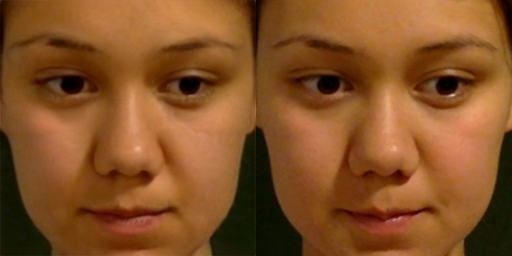

In [9]:
# Display inversion:
display_alongside_source_image(tensor2im(result_image), original_image)

In [10]:
# transform image to tensor
tf_img_to_tensor = transforms.ToTensor()
img_tensor = tf_img_to_tensor(original_image)
print(img_tensor.size())
# img_tensor

torch.Size([3, 448, 448])


<class 'PIL.Image.Image'>


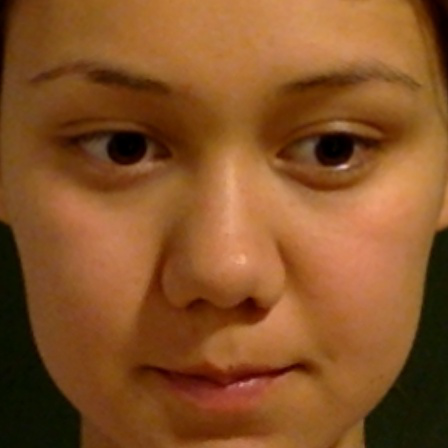

In [11]:
# transform tensor to image
tf_tensor_to_img = transforms.ToPILImage()
tensor_img = tf_tensor_to_img(img_tensor)
print(type(tensor_img))
tensor_img

# tensor type latent
print(type(latent))
print(latent.shape)
# Change type to numpy
latent_numpy = latent.cpu().numpy()
print(latent_numpy.shape)
# Save numpy (.npy)
np.save('./1-2_latent_numpy',latent_numpy)

In [12]:
# load numpy type latent
np_load = np.load('./1-0_latent_numpy.npy')
print(np_load.shape)

(16, 512)


In [13]:
class LatentEditor(object):
    def __init__(self, stylegan_generator):
        self.generator = stylegan_generator

    # Currently, in order to apply StyleFlow editings, one should run inference,
    # save the latent codes and load them form the official StyleFlow repository.
    # def apply_styleflow(self):
    #     pass

    def _latents_to_image(self, latents):
        with torch.no_grad():
            images, _ = self.generator([latents], randomize_noise=False, input_is_latent=True)
        horizontal_concat_image = torch.cat(list(images), 2)
        final_image = tensor2im(horizontal_concat_image)
        return final_image

In [14]:
editor = LatentEditor(net.decoder)

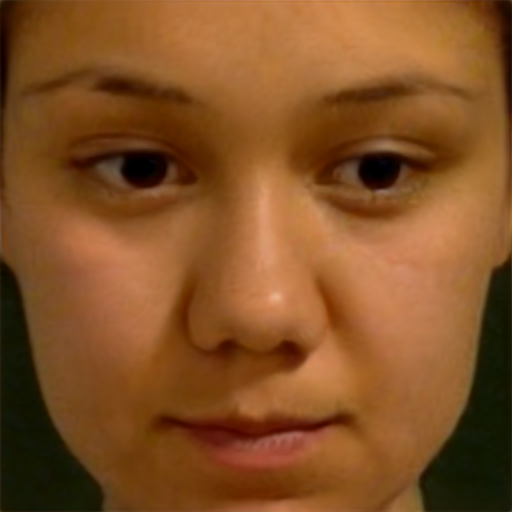

In [15]:
editor._latents_to_image(latents)

In [16]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos_sim(A,B):
    return dot(A,B)/(norm(A)*norm(B))

# Comapare image similarity

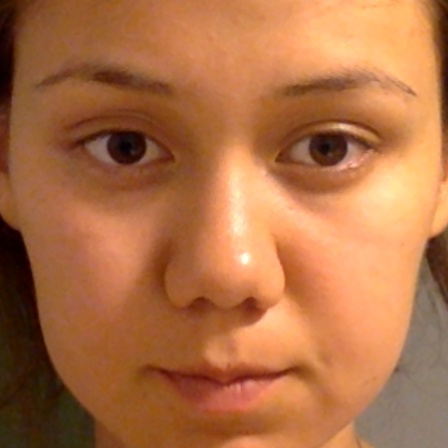

In [17]:
test1_image = Image.open("./notebooks/images/1-0.jpg")
np_test1_image = np.array(test1_image)
test1_image = Image.fromarray(np_test1_image)
test1_image

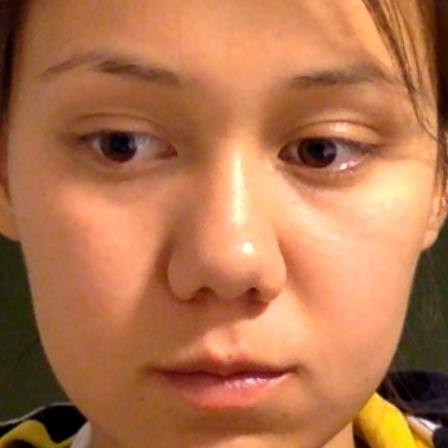

In [18]:
test2_image = Image.open("./notebooks/images/1-1.jpg")
np_test2_image = np.array(test2_image)
test2_image = Image.fromarray(np_test2_image)
test2_image

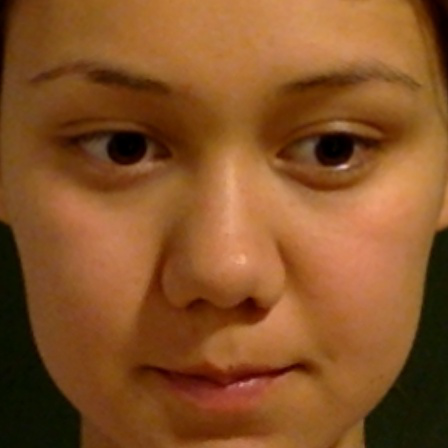

In [19]:
test11_image = Image.open("./notebooks/images/1-2.jpg")
np_test11_image = np.array(test11_image)
test11_image = Image.fromarray(np_test11_image)
test11_image

In [20]:
latents

tensor([[[ 0.2856,  0.2714, -0.4513,  ..., -0.3211, -0.0069, -0.3035],
         [ 0.3752,  0.4319, -0.6997,  ..., -0.5083,  0.1255, -0.2102],
         [ 0.4964,  0.5938, -0.4818,  ..., -0.1833, -0.1235,  0.6556],
         ...,
         [ 0.3405, -0.0913, -0.6091,  ...,  0.0957,  0.2517, -0.1911],
         [ 0.2855,  0.2718, -0.4515,  ..., -0.3206, -0.0069, -0.3029],
         [ 0.1827,  0.3473, -0.4143,  ..., -0.0998, -0.1093, -0.2493]]],
       device='cuda:0')

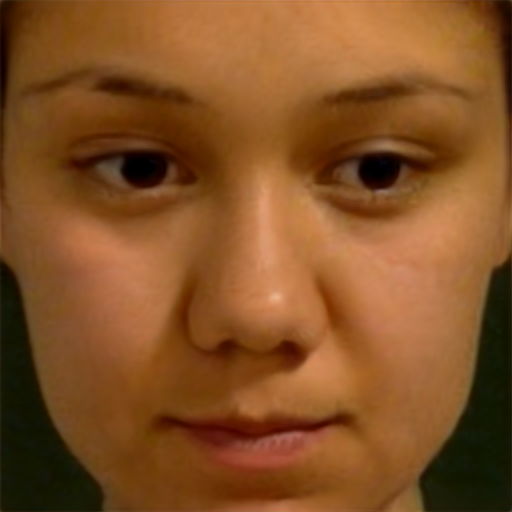

In [21]:
editor._latents_to_image(latents)

# npy to image

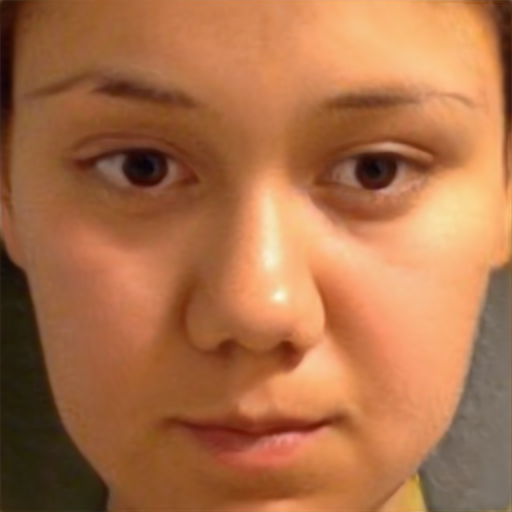

In [27]:
np_load0 = np.load('./1-0_latent_numpy.npy')
np_load0 = torch.from_numpy(np_load0).to('cuda')
np_load0 = torch.unsqueeze(np_load0,0)
editor._latents_to_image(np_load0)

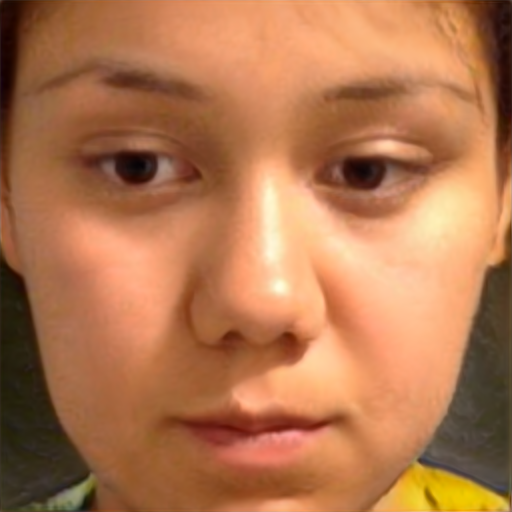

In [28]:
np_load1 = np.load('./1-1_latent_numpy.npy')
np_load1 = torch.from_numpy(np_load1).to('cuda')
np_load1 = torch.unsqueeze(np_load1,0)
editor._latents_to_image(np_load1)

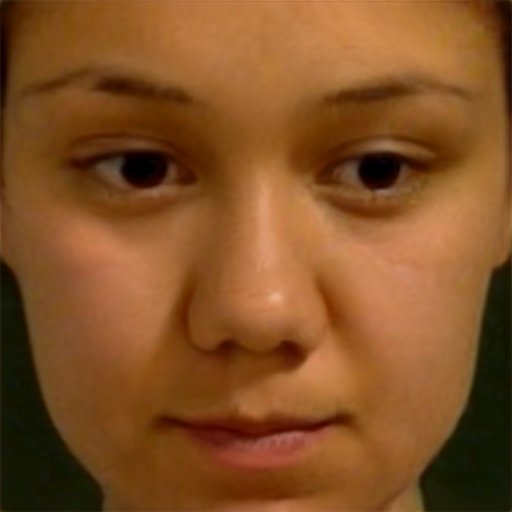

In [29]:
np_load2 = np.load('./1-2_latent_numpy.npy')
np_load2 = torch.from_numpy(np_load2).to('cuda')
np_load2 = torch.unsqueeze(np_load2,0)
editor._latents_to_image(np_load2)

In [30]:
latents

tensor([[[ 0.2856,  0.2714, -0.4513,  ..., -0.3211, -0.0069, -0.3035],
         [ 0.3752,  0.4319, -0.6997,  ..., -0.5083,  0.1255, -0.2102],
         [ 0.4964,  0.5938, -0.4818,  ..., -0.1833, -0.1235,  0.6556],
         ...,
         [ 0.3405, -0.0913, -0.6091,  ...,  0.0957,  0.2517, -0.1911],
         [ 0.2855,  0.2718, -0.4515,  ..., -0.3206, -0.0069, -0.3029],
         [ 0.1827,  0.3473, -0.4143,  ..., -0.0998, -0.1093, -0.2493]]],
       device='cuda:0')

In [72]:
#same
latent_sim = torch.squeeze(latents,0)
latent_sim = latent_sim.cpu().numpy()
cos_sim(latent_sim.flatten(), np_load11_sim.flatten())

1.0000001

In [117]:
# latent_sim = torch.from_numpy(latent_sim).to('cuda')
# np_load2_sim = torch.from_numpy(np_load2_sim).to('cuda')

# Change latent vector

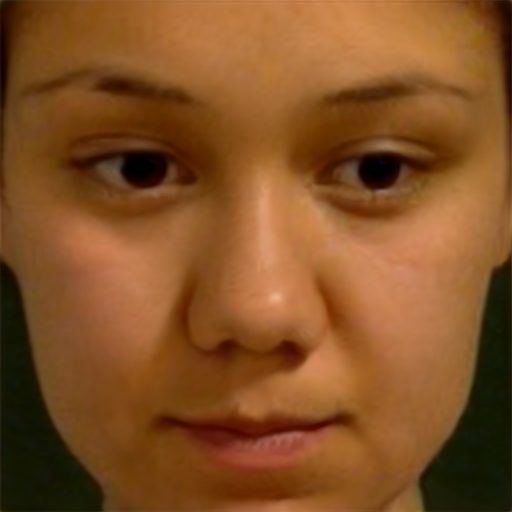

In [32]:
np_load2 = np.load('./1-2_latent_numpy.npy')
np_load2 = torch.from_numpy(np_load2).to('cuda')
np_load2 = torch.unsqueeze(np_load2,0)
editor._latents_to_image(np_load2)

In [391]:
# 1 left || 2 right

In [512]:
a = abs(np_load2 - np_load1)

a = a.squeeze(0)

In [515]:
abs_load1_load2 = torch.max(a, dim=1)
abs_load1_load2[1]

tensor([439, 483, 163, 505, 285,  79, 444, 378, 423, 394, 467, 193, 429,  34,
        439, 248], device='cuda:0')

In [516]:
abs_load1_load2[0]

tensor([0.8314, 1.2964, 1.1657, 1.1604, 1.3802, 1.4852, 1.2114, 1.3742, 1.1268,
        1.5736, 0.9432, 1.0724, 0.8314, 1.0617, 0.8317, 0.8497],
       device='cuda:0')

In [517]:
x = 0
for v in abs_load1_load2[1]:
    print(np_load2[0][x][v])

tensor(1.7647, device='cuda:0')
tensor(-0.6461, device='cuda:0')
tensor(-0.0222, device='cuda:0')
tensor(0.6445, device='cuda:0')
tensor(-0.0998, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(-0.9328, device='cuda:0')
tensor(0.7454, device='cuda:0')
tensor(0.4968, device='cuda:0')
tensor(-0.0971, device='cuda:0')
tensor(0.4987, device='cuda:0')
tensor(0.9546, device='cuda:0')
tensor(0.9393, device='cuda:0')
tensor(1.0860, device='cuda:0')
tensor(1.7647, device='cuda:0')
tensor(2.1657, device='cuda:0')


In [518]:
np_load1[0][0][16]

tensor(-0.0301, device='cuda:0')

In [519]:
np_load2[0][0][16]

tensor(-0.0301, device='cuda:0')

In [520]:
x = 0

for z in abs_load1_load2[1]:
    np_load2[0][x][z] = np_load1[0][x][z]
    np_load2[0][x][z]
    x += 1

In [521]:
x = 0
for v in abs_load1_load2[1]:
    print(np_load2[0][x][v])

tensor(0.9333, device='cuda:0')
tensor(-0.6461, device='cuda:0')
tensor(-0.0222, device='cuda:0')
tensor(0.6445, device='cuda:0')
tensor(-0.0998, device='cuda:0')
tensor(0.1888, device='cuda:0')
tensor(-0.9328, device='cuda:0')
tensor(0.7454, device='cuda:0')
tensor(0.4968, device='cuda:0')
tensor(-0.0971, device='cuda:0')
tensor(0.4987, device='cuda:0')
tensor(0.9546, device='cuda:0')
tensor(0.9393, device='cuda:0')
tensor(1.0860, device='cuda:0')
tensor(0.9333, device='cuda:0')
tensor(2.1657, device='cuda:0')


In [665]:
location = []

In [666]:
def change(np_load1,np_load2):
    a = abs(np_load2 - np_load1)
    a = a.squeeze(0)
    abs_load1_load2 = torch.max(a, dim=1)
    x = 0
    for z in abs_load1_load2[1]:
        np_load2[0][x][z] = np_load1[0][x][z]
        np_load2[0][x][z]
        location.append([x,z])
        x += 1

In [667]:
for i in range(30):
    change(np_load1,np_load2)

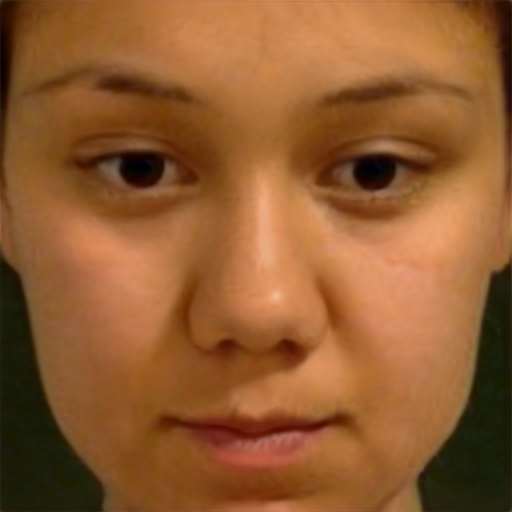

In [668]:
editor._latents_to_image(np_load2)

In [662]:
Image_result = editor._latents_to_image(np_load2)

print(type(Image_result))
Image_result.save('2400tensor_change_result.png')

<class 'PIL.Image.Image'>


In [671]:
np_load2

tensor([[[ 0.2856,  0.2714, -0.4513,  ..., -0.3211, -0.0069, -0.3035],
         [ 0.3752,  0.4319, -0.6997,  ..., -0.5083,  0.1255, -0.2102],
         [ 0.4964,  0.5938, -0.4818,  ..., -0.1833, -0.1235,  0.6556],
         ...,
         [ 0.3405, -0.0913, -0.6091,  ...,  0.0957,  0.2517, -0.1911],
         [ 0.2855,  0.2718, -0.4515,  ..., -0.3206, -0.0069, -0.3029],
         [ 0.1827,  0.3473, -0.4143,  ..., -0.0998, -0.1093, -0.2493]]],
       device='cuda:0')

In [672]:
np_load1

tensor([[[ 0.7501,  0.1865,  0.0076,  ..., -0.5296, -0.3818, -0.2836],
         [ 1.0782, -0.0524, -0.3070,  ..., -0.5469,  0.2170,  0.0984],
         [ 0.8422, -0.0771,  0.5555,  ..., -0.1210, -0.3406,  0.2002],
         ...,
         [ 0.9299,  0.1618,  0.1730,  ..., -0.4359, -0.2740, -0.4374],
         [ 0.7502,  0.1871,  0.0073,  ..., -0.5295, -0.3821, -0.2835],
         [ 0.6282,  0.3844, -0.0343,  ..., -0.3212, -0.4537, -0.2119]]],
       device='cuda:0')

In [673]:
import numpy as np #numpy library
np.set_printoptions(linewidth=np.inf) #inf = infinity 

LLLL = sum(sum(np_load2.cpu().numpy() == np_load1.cpu().numpy()))
LLLL

array([ 1,  0,  0,  0,  0,  0,  2,  2,  1,  0,  0,  0,  0,  0,  0,  0, 10,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,  0,  0,  2,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  2,  1,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  0,  2,  0,  8,  9,  0,  0,  0,  0,  0,  1,  1,  0,  0,  1,  0,  1,  3,  0,  0,  1,  0,  0,  3,  4,  1,  1,  1,  3,  0,  2,  1,  0,  0,  0,  0,  0,  3,  0,  7,  3,  0,  1,  0,  0,  0,  0,  1,  0,  1,  0,  1,  1,  0,  1,  0,  1, 11,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  1,  0,  1,  0,  0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  2,  9, 11,  0,  0,  0,  3,  0,  1,  0,  4,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  0,  1,  0,  0,  0,  2,  2,  0,  0,  0,  1,  1,  0,  0,  0, 10,  0,  0,  0,  1,  0,  1,  1,  0,  0,  

In [674]:
sum(LLLL)

480

In [679]:
ten_num = location[0][1].cpu().detach().numpy()
ten_num

array(301)

In [684]:
index = []
for i in location:
    index.append([i[0],int(i[1].cpu().detach().numpy())])

In [689]:
x_axis = []
y_axis = []

In [690]:
for i in index:
    x_axis.append(i[0])
    y_axis.append(i[1])

In [710]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(x_axis, y_axis, s=10**2)
plt.show()

In [706]:
print(len(x_axis))

480


In [707]:
print(len(y_axis))

480
